# Geração de dataset da solução da equação de Kuramoto-Sivashinsky em 1D.

A equação de Kuramoto-Sivashinsky (KS) é utilizada em diversas aplicações como um modelo de turbulência, devido à natureza caótica de sua solução. Sua forma geral é: $$u_t = -\nu u_{xxxx} -u_{xx} -uu_{x}$$

Kassam e Trefethen (2005) demonstra um método numérico para resolver essa equação, uilizando diferenciação temporal exponencial com um método de Runge-Kutta de quarta ordem modificado (método ETDRK4). Com esse método, a equação é levada ao domínio da frequência pela transfomada de Fourier no domínio do espaço, sendo $k$ o vetor de onda:
$$\begin{aligned}
\mathcal{F}\left[u\right]=&\hat{u}\\
\mathcal{F}\left[u_t\right]=&\hat{u_t}\\
\hat{u_t} =& -\frac{ik}{2}\hat{u^2} + \left(k^2-k^4\right)\hat{u}
\end{aligned}$$

A equação acima pode ainda ser reescrita em função de um operador linear $L(k)$ e um operador não-linear $N(\hat{u}, k)$:
$$\begin{aligned}
L(k)=& k^2-k^4\\
N(\hat{u}, k)=&-\frac{ik}{2}\left(\mathcal{F}\left(\left(\mathcal{F}^{-1}\left(\hat{u}\right)\right)^2 \right)\right)\\
\hat{u_t} =& L(k)\hat{u} + N(\hat{u}, k)
\end{aligned}$$

Com esses operadores definidos, o método ETDRK define o próximo passo temporal como:
$$
u_{n+1} = e^{Lh}u_n + h\sum^{s-1}_{m=0}g_m\sum^{m}_{k=0}(-1)^k\left(\begin{aligned}&m\\&k\end{aligned}\right)N_{n,k}
$$
Sendo $h$ o passo temporal, $n$ o instante no tempo, e $g_m$ coeficientes dads pela relação de recorrência:
$$\begin{aligned}
Lhg_0 =& e^{Lh}-I\\
Lhg_{m+1} + I =& \sum^{m}_{k=0}\frac{g_k}{m+1-k},\; m\geq0
\end{aligned}$$

Considerando um problema de quarta ordem, pode-se manipular algebricamente as expessões acima para chegar-se em uma fórmula direta para o próximo passo de tempo. Cox e Matthews (2002) chegaram na seguinte fórmula para esse método:
$$\begin{aligned}
a_n =& E_2\cdot u_n + Q\cdot N(u_n)\\
b_n =& E_2\cdot u_n + Q\cdot N(a_n)\\
c_n =& E_2\cdot a_n + Q\cdot \left(2N(b_n) - N(u_n)\right)\\
u_{n+1} =& E_1 + f_1\cdot N(u_n) +2f_2\cdot\left(N(a_n) + N(b_n)\right) + f_3\cdot N(c_n)
\end{aligned}$$
Sendo:
$$\begin{aligned}
E_1 =& e^{Lh}\\
E_2 =& e^{Lh/2}\\
Q =& L^{-1}\left(E_2 - I\right)\\
f_1 =& h^{-2}L^{-3}\left[ -4 -Lh +E_1\left(4-3Lh+(Lh)^2\right) \right]\\
f_2 =& 2h^{-2}L^{-3}\left[ 2 +Lh + E_1(-2+Lh) \right]\\
f_3 =& h^{-2}L^{-3}\left[ -4 -3Lh -(Lh)^2 + E_1(4-Lh) \right]
\end{aligned}$$

In [17]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fftpack import fft, ifft
from IPython.display import clear_output
import pandas as pd
from time import time


In [18]:
# Funcao para pular alguns frames
def skipp(lista, nn):
    ll = []
    for ii in range(0, len(lista), int(nn)):
        ll.append(ii)
    return np.array(ll)


def resize(lista, nn):
    if not hasattr(nn, '__iter__'):
        return lista[np.linspace(0, len(lista)-1, nn, dtype=int)]
    else:
        ll = lista[np.linspace(0, len(lista)-1, nn[0], dtype=int)]
        ll2 = np.array([resize(ll[0], nn[1])])
        for ii in range(1, nn[0]):
            ll2 = np.append(ll2, [resize(ll[ii], nn[1])], axis=0)
        return ll2

In [19]:
# ETDRK4 (Kassam, 2005)
def etdrk4():
    start = time()
    k = np.concatenate((np.arange(0, N/2), [0], np.arange(-N/2+1, 0)))/(L/(2*np.pi))
    LL = k**2 - nu*k**4
    E1 = np.exp(dt*LL)
    E2 = np.exp(dt*LL/2)
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
    LR = dt*np.array(M*[LL]).T + np.array(N*[r])
    Q = dt*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = dt*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = dt*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = dt*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

    uu = np.array([u0])
    v = fft(u0)
    k2 = -0.5j*k
    for i in range(1, len(t)):
        Nv = k2*fft(np.real(ifft(v))**2)
        a = E2*v + Q*Nv
        Na = k2*fft(np.real(ifft(a))**2)
        b = E2*v + Q*Na
        Nb = k2*fft(np.real(ifft(b))**2)
        c = E2*a + Q*(2*Nb-Nv)
        Nc = k2*fft(np.real(ifft(c))**2)
        v = E1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        uu = np.append(uu, [np.real(ifft(v))], axis=0)
        if (100*i/len(t))%5 == 0:
            clear_output(wait=True)
            print(str(int(100*i/len(t)))+'% solution')
        if i == len(t)-1:
            clear_output(wait=True)
            print('Done solution')
    end = time()
    print('Tempo para solucao:', end - start)
    return uu


In [ ]:
# Solucao
# os dados aqui sao iguais aos do Kassam, mas tambem testamos com N=512, L=64pi, tmax=6e4 e o programa resolveu, so que demorou algumas horas. Salvamos o .csv da solucao com os dados do Vlachas pra nao precisar rodar de novo
nu = 1
N = 128         # numero de nos
L = 32*np.pi    # comprimento do dominio
dx = L/N        # passo no espaco
x = L*np.arange(1,N+1)/N    # posicao dos nos

dt = 0.25       # passo no tempo
tmax = 150      # tempo final
t = np.arange(0, tmax, dt)    # vetor tempo

nmax = np.round(tmax/dt)

u0 = np.cos(2*np.pi*x/L)*(1+np.sin(2*np.pi*x/L))  # condicao inicial
# u0 = (np.random.rand(N) -0.5)*0.01
u = etdrk4()


75% solution


In [21]:
# Salvando os resultados
nome = 'kuramoto'+'-L'+str(int(L))+'-N'+str(int(N))+'-t'+str(int(tmax))+'-dt.'+str(int(dt*100))+'.csv'
df = pd.DataFrame(u, columns=x, index=t)
df.to_csv(nome)

<IPython.core.display.Javascript object>


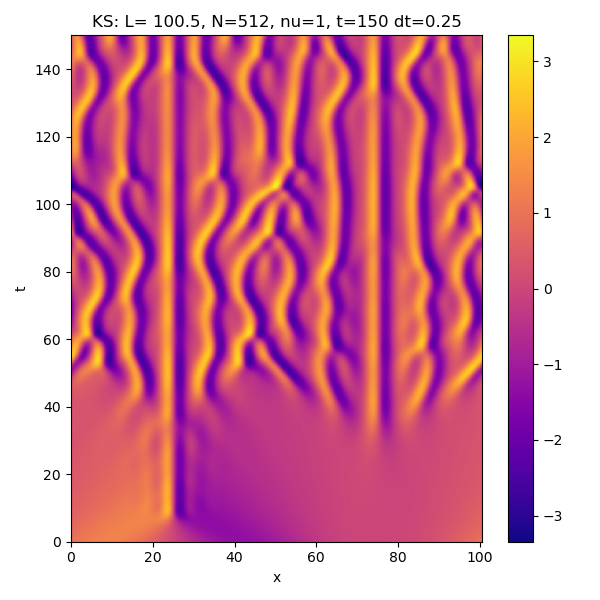

In [22]:
# plot the result
plt.close()
fig, ax = plt.subplots(figsize=(6,6))

# xx, tt = np.meshgrid(x, t)
# levels = np.arange(-3, 3, 0.01)
# cs = ax.contourf(xx, tt, u.T, cmap=cm.jet)
# fig.colorbar(cs)

nx = 300*(N>=300) + N*(N<300)
nt = 300*(len(t)>=300) + len(t)*(len(t)<300)
cc = ax.pcolormesh(resize(x, nx), resize(t, nt), resize(u, (nx,nt)),
                   cmap='plasma', shading='gouraud')
fig.colorbar(cc, ax=ax)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title(f'KS: L={L: .1f}, N={N}, nu={nu}, t={tmax} dt={dt}')
ax.set_xlim(0, L)
ax.set_ylim(0, tmax)
fig.tight_layout()

nome = 'kuramoto'+'-L'+str(int(L))+'-N'+str(int(N))+'-t'+str(int(tmax))+'-dt.'+str(int(dt*100))+'.png'
fig.savefig(nome, dpi=400)


<IPython.core.display.Javascript object>


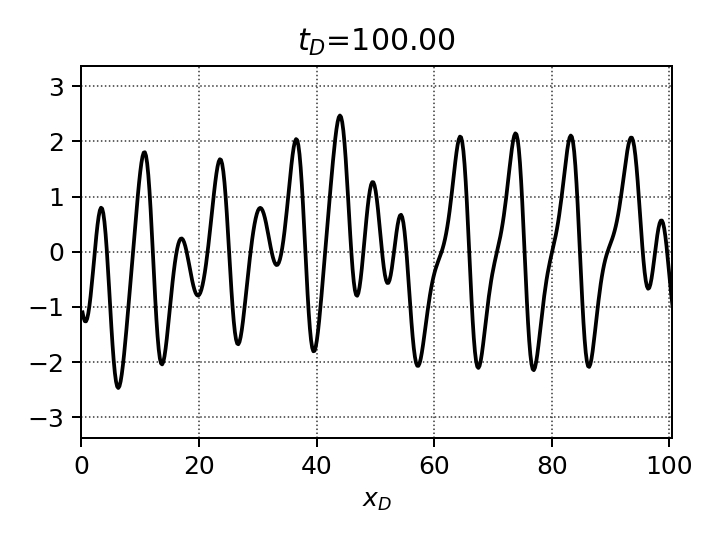

In [23]:
# Animacao
fig2, ax2 = plt.subplots(figsize=(4, 3), dpi=180)
ax2.set_xlim(0, L)
d = (np.amin(u)+np.amax(u))*0.05
ax2.set_ylim(np.amin(u)-d, np.amax(u)-d)
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

def anifunc(frame):
    # Plot
    ax2.clear()
#     ax2.fill_between(x, sw[frame]+so[frame], sw[frame], ec='#e6a122', fc='#ffd485')
#     ax2.fill_between(x, sw[frame], ec='#156ced', fc='#85b6ff')
    ax2.plot(x, u[frame], c='k')
#     ax2.plot(x, u_vf[frame], c='k', ls='-.', alpha=0.8)
    
    # Ajustes do plot
    ax2.set_xlim(0, L)
    ax2.set_ylim(np.amin(u)-d, np.amax(u)-d)
    ax2.set_xlabel('$x_D$')
    ax2.set_title('$t_D$={t:.2f}'.format(t=t[frame]))
    ax2.grid(which='both', c='k', alpha=0.8, ls=':', lw=0.6)
    
    # Legenda
#     legenda = [Line2D([0], [0], color='#156ced', label='$S_{w,an}$'),
#                Line2D([0], [0], color='#b0340b', ls='--', label='$S_{w,df}$'),
#                Line2D([0], [0], color='k', ls='-.', label='$S_{w,vf}$')]
#     ax2.legend(handles=legenda, loc='center left', bbox_to_anchor=(1, 0.5))
    fig2.tight_layout()
    return []

ani = FuncAnimation(fig2, anifunc, frames=skipp(t, 10), interval=17)